In [25]:
# All libraries required for the code
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# Data Acquisition from Kaggle ("https://www.kaggle.com/code/vbmokin/used-cars-price-prediction-by-15-models")
file_path = "dataset_cars.csv"
df = pd.read_csv(file_path)

In [27]:
# Data Cleaning and Feature Engineering Phase
df.dropna(inplace=True)
df = df[(df['price'] >= 1000) & (df['price'] <= 100000)]
df = df[df['odometer'] < 3000000]
categorical_cols = ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color']
for col in categorical_cols:
    df[col] = df[col].str.lower()
df.drop_duplicates(inplace=True)
# created a new feature car_age with current year as the reference point.
df['car_age'] = 2025 - df['year']
df.drop(columns=['year'], inplace=True)
df_copy_benc=df.copy(deep=True)
# Encoding categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df_copy_benc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103045 entries, 0 to 525836
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         103045 non-null  int64  
 1   manufacturer  103045 non-null  object 
 2   condition     103045 non-null  object 
 3   cylinders     103045 non-null  object 
 4   fuel          103045 non-null  object 
 5   odometer      103045 non-null  float64
 6   transmission  103045 non-null  object 
 7   drive         103045 non-null  object 
 8   type          103045 non-null  object 
 9   paint_color   103045 non-null  object 
 10  car_age       103045 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 9.4+ MB


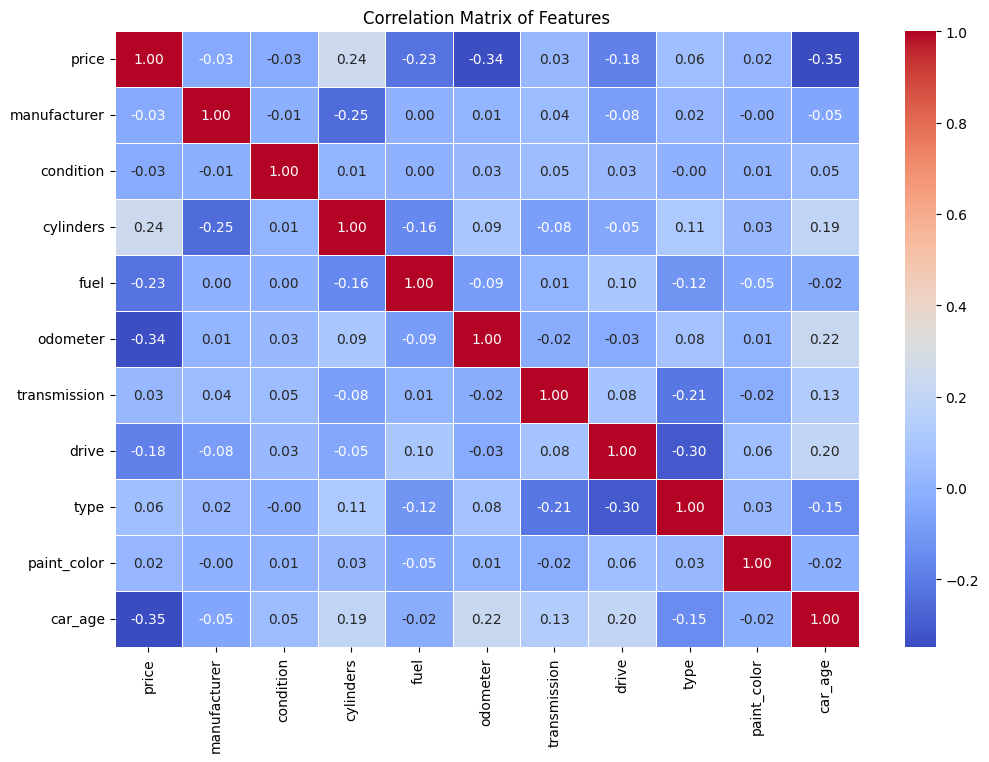

In [10]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

In [11]:
# Splitting the dataset into features (X) and target variable (y)
X = df.drop(columns=['price'])
y = df['price']
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Using the below models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Support Vector Machine": SVR()
}
# Training and Testing the cleaned dataset with the above models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}
    print(f"{name} Results:")
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2:.2f}\n")
    
# Stacked Regression
stacked_model = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
        ('gbr', GradientBoostingRegressor(n_estimators=50, random_state=42)),
        ('dt', DecisionTreeRegressor(random_state=42))
    ], final_estimator=LinearRegression()
)
stacked_model.fit(X_train, y_train)
y_pred_stacked = stacked_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_stacked)
mse = mean_squared_error(y_test, y_pred_stacked)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_stacked)
results["Stacked Regression"] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}
print("Stacked Regression Results:")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2:.2f}\n")

Linear Regression Results:
MAE: 4987.26, MSE: 57320102.91, RMSE: 7571.00, R2 Score: 0.38

Random Forest Results:
MAE: 2423.12, MSE: 16903928.96, RMSE: 4111.44, R2 Score: 0.82

Decision Tree Results:
MAE: 3223.34, MSE: 29921421.87, RMSE: 5470.05, R2 Score: 0.68

Gradient Boosting Results:
MAE: 2728.99, MSE: 20319662.80, RMSE: 4507.73, R2 Score: 0.78

Support Vector Machine Results:
MAE: 5589.85, MSE: 80410403.50, RMSE: 8967.18, R2 Score: 0.13

Stacked Regression Results:
MAE: 2422.13, MSE: 16766797.45, RMSE: 4094.73, R2 Score: 0.82



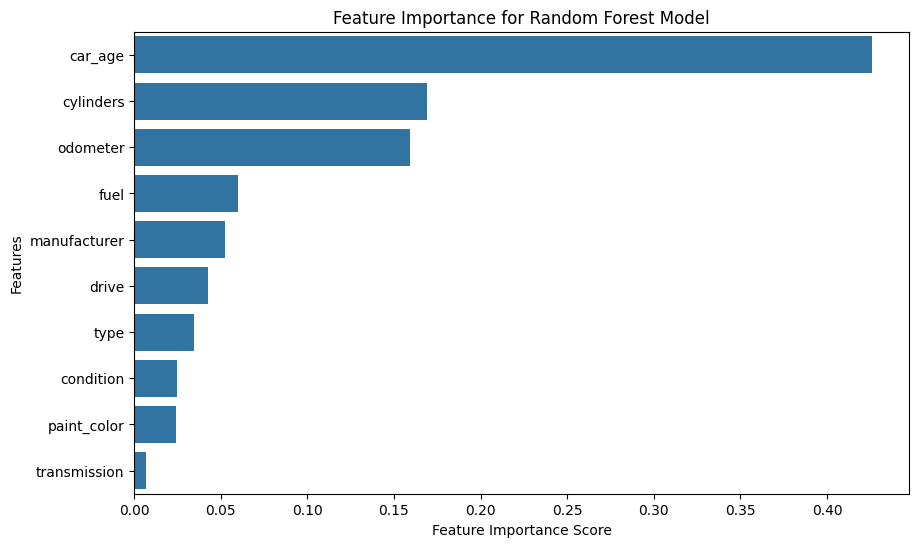

In [13]:
# Feature Importance using RandomForestRegression (RandomForest came out with best precision)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance for Random Forest Model")
plt.show()

'price' → lower = -17,100, upper = 40,500, outliers = 11513
  Sample outliers: [40990, 48955, 44500, 41400, 48999]

'odometer' → lower = -83,315, upper = 270,789, outliers = 4544
  Sample outliers: [332311.0, 7400098.0, 1000000.0, 271000.0, 329000.0]



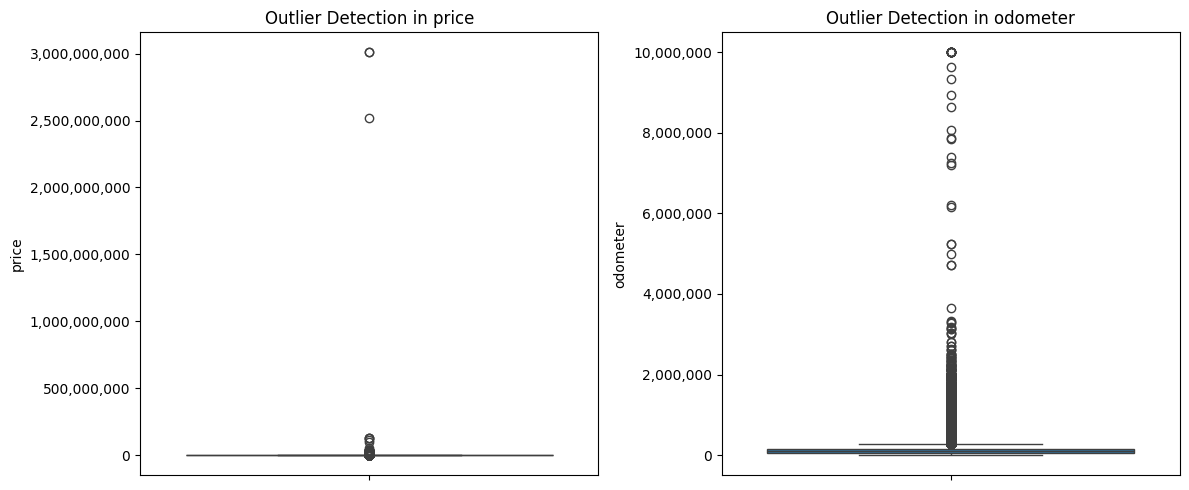

In [21]:
## Outliers Observation before cleaning data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Reading in chunks and build raw DataFrame
chunk_iter = pd.read_csv('dataset_cars.csv', chunksize=50000)
df_list = []
for chunk in chunk_iter:
    chunk = chunk[['price', 'odometer', 'year']].dropna()
    chunk['car_age'] = 2025 - chunk['year']
    chunk.drop(columns='year', inplace=True)
    df_list.append(chunk)
df_raw = pd.concat(df_list, ignore_index=True)

# Calculating IQR thresholds and extracting outliers
outlier_info = {}
for col in ['price', 'odometer']:
    Q1 = df_raw[col].quantile(0.25)
    Q3 = df_raw[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    mask = (df_raw[col] < lower) | (df_raw[col] > upper)
    outliers = df_raw.loc[mask, col]
    outlier_info[col] = {
        'lower_bound': lower,
        'upper_bound': upper,
        'count': outliers.shape[0],
        'sample_values': outliers.head().tolist()
    }
    print(f"{col!r} → lower = {lower:,.0f}, upper = {upper:,.0f}, outliers = {outliers.shape[0]}")
    print(f"  Sample outliers: {outlier_info[col]['sample_values']}\n")

# Plotting boxplots for price & odometer
plt.figure(figsize=(12, 5))
for i, col in enumerate(['price', 'odometer'], 1):
    ax = plt.subplot(1, 2, i)
    sns.boxplot(y=df_raw[col], ax=ax)
    ax.set_title(f'Outlier Detection in {col}')
    ax.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f"{int(x):,}")
    )
plt.tight_layout()
plt.show()

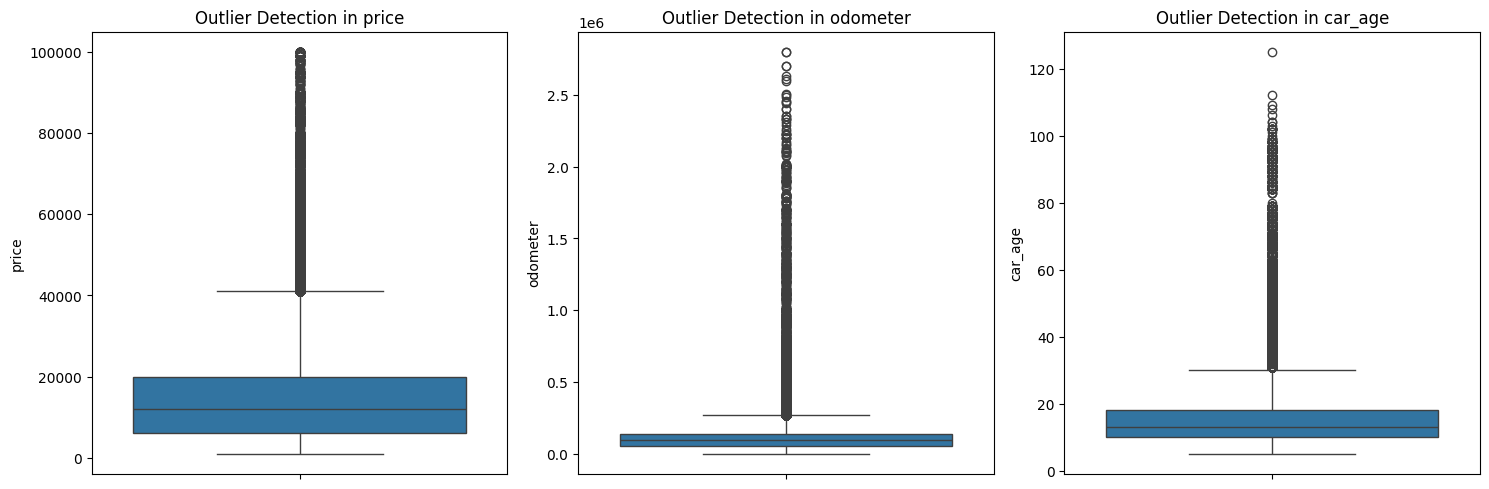

In [22]:
# outliers observation afte cleaning data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Reading dataset in chunks to avoid memory issues
chunk_iter = pd.read_csv('dataset_cars.csv', chunksize=50000)
# Concatenate only necessary columns to reduce memory usage
df_list = []
for chunk in chunk_iter:
    # Selecting only relevant columns
    chunk = chunk[['price', 'odometer', 'year']]
    chunk.dropna(inplace=True)
    chunk = chunk[(chunk['price'] >= 1000) & (chunk['price'] <= 100000)]
    chunk = chunk[chunk['odometer'] < 3000000]
    chunk['car_age'] = 2025 - chunk['year']
    chunk.drop(columns=['year'], inplace=True)
    df_list.append(chunk)
# Combine all chunks into a single DataFrame
df_reduced = pd.concat(df_list, ignore_index=True)
# Plotting boxplots to detect outliers in numerical columns
numerical_cols = ['price', 'odometer', 'car_age']
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df_reduced[col])
    plt.title(f'Outlier Detection in {col}')
plt.tight_layout()
plt.show()